## Question: "How do plan rates vary by age?"

In [1]:
import sys
import copy
import matplotlib.pyplot as plt
import numpy as np
sys.path.append("..") # Make root modules available to this script

from classes.sqliteTableExplorer import SqliteTableExplorer

# Use class to connect and create a cursor for querying the database
sqlite_table_explorer = SqliteTableExplorer()

'Rate' table plan rate information but we can also see that it has state infomation (IndividualRate) so dont need to join with another table to answer this question, only this will be enough

In [2]:
table = "Rate"
print(f"----{table}----", *sqlite_table_explorer.get_table_col_types(table), sep="\n")

----Rate----
('BusinessYear', 'INTEGER')
('StateCode', 'TEXT')
('IssuerId', 'INTEGER')
('SourceName', 'TEXT')
('VersionNum', 'INTEGER')
('ImportDate', 'TEXT')
('IssuerId2', 'INTEGER')
('FederalTIN', 'TEXT')
('RateEffectiveDate', 'TEXT')
('RateExpirationDate', 'TEXT')
('PlanId', 'TEXT')
('RatingAreaId', 'TEXT')
('Tobacco', 'TEXT')
('Age', 'TEXT')
('IndividualRate', 'NUMERIC')
('IndividualTobaccoRate', 'NUMERIC')
('Couple', 'NUMERIC')
('PrimarySubscriberAndOneDependent', 'NUMERIC')
('PrimarySubscriberAndTwoDependents', 'NUMERIC')
('PrimarySubscriberAndThreeOrMoreDependents', 'NUMERIC')
('CoupleAndOneDependent', 'NUMERIC')
('CoupleAndTwoDependents', 'NUMERIC')
('CoupleAndThreeOrMoreDependents', 'NUMERIC')
('RowNumber', 'INTEGER')


Looking at the columns the ones we will need are "IndividualRate" and "Age", this is important since full disc scan can be very slow using sqlite3, but getting specific columns if fast.

In [4]:
Rate = sqlite_table_explorer.read("Rate",["Age", "IndividualRate"])

First lets see the range for the age values.

In [21]:
print(Rate["Age"].value_counts())

Age
0-20             275489
21               275067
22               275067
24               275067
23               275067
25               275067
26               275067
30               275067
27               275067
28               275067
29               275067
32               275067
31               275067
33               275067
34               275067
50               275067
35               275067
36               275067
37               275067
38               275067
39               275067
40               275067
41               275067
42               275067
43               275067
44               275067
45               275067
46               275067
47               275067
48               275067
49               275067
58               275067
51               275067
52               275067
53               275067
54               275067
55               275067
56               275067
57               275067
62               275067
59               275067
60          

We see there is a family option so because this does not correspond to any age, we will remove this category for the rest of the analysis. Also to simplify following calculations we will label "65 and over" as 65, as what we are interested to see is the rate trends when ages differ and changing this will not affect the final results.

In [39]:
rate_copy = copy.copy(Rate) #make a shallow copy so we dont touch the original data
rate_copy = rate_copy.loc[rate_copy["Age"]!="Family Option",]
rate_copy.loc[rate_copy["Age"]=="65 and over","Age"] = "65"

count    1.269444e+07
mean     4.098026e+03
std      6.122271e+04
min      0.000000e+00
25%      2.933000e+01
50%      2.916000e+02
75%      4.789800e+02
max      9.999990e+05
Name: IndividualRate, dtype: float64


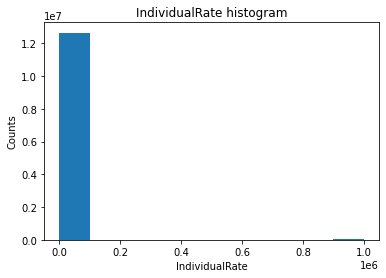

In [40]:
fig, ax = plt.subplots(1, 1) 
plt.hist(Rate["IndividualRate"])
ax.set_title("IndividualRate histogram")
ax.set_xlabel("IndividualRate")
ax.set_ylabel("Counts")
print(Rate["IndividualRate"].describe())
plt.show()

We see from the summary statistics that 75% of the data are less than 5000 so lets create 2 bins (split on value 5000) and zoom in the data to see them.

In [41]:
rate_copy.loc[rate_copy["IndividualRate"]>=5000,"IndividualRate"].value_counts()

IndividualRate
999999.00    47790
9999.00      23580
9999.99       1080
5079.20          4
5254.85          4
5006.03          4
5017.40          4
5112.26          4
5170.77          2
5032.40          2
5030.47          2
5220.50          2
5046.02          2
5078.84          2
5503.85          2
5259.14          2
5319.89          2
5243.24          2
5255.15          2
5224.10          2
5116.43          2
5354.51          2
5204.78          2
5053.07          2
5083.37          2
5021.51          2
5010.11          2
5136.98          1
5415.80          1
5270.86          1
5155.28          1
5140.51          1
5002.95          1
5021.29          1
5159.36          1
5171.09          1
5094.69          1
5234.78          1
5032.71          1
5175.00          1
5036.51          1
5268.84          1
5127.84          1
5121.52          1
5015.40          1
5002.04          1
5034.58          1
Name: count, dtype: int64

Aha! We see that for IndividualRates >= 6000 theres a concentration around 3 numbers and they appear a lot of times but these values seem to be out of place, since theres no other values around them, so we can label them as outliers or they may have a special meaning to the authors.
For the rest of the analysis we will focus on IndividualRate values < 6000.

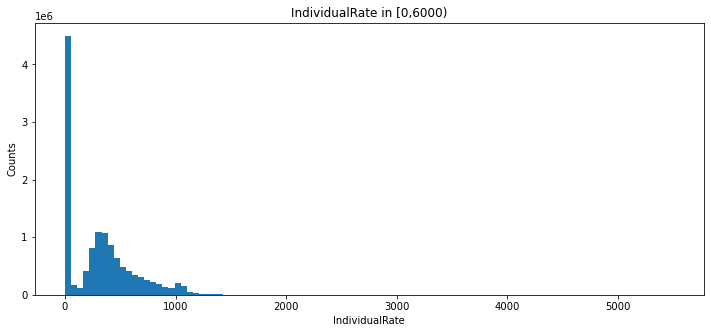

In [42]:
rate_copy = rate_copy.loc[rate_copy["IndividualRate"]<6000,]
fig, ax = plt.subplots(1, 1, figsize=(12, 5))

# Let's use bins=100 so we get 100 values in each bin.
ax.hist(rate_copy["IndividualRate"], bins = 100)
ax.set_title("IndividualRate in [0,6000)")
ax.set_xlabel("IndividualRate")
ax.set_ylabel("Counts")

plt.show()

We see that there's a lot of values having 0 rate and then the data follows a right skewed distribution which means most rates sold exist in the lower price range and the more expensive it gets, the less people choose it.

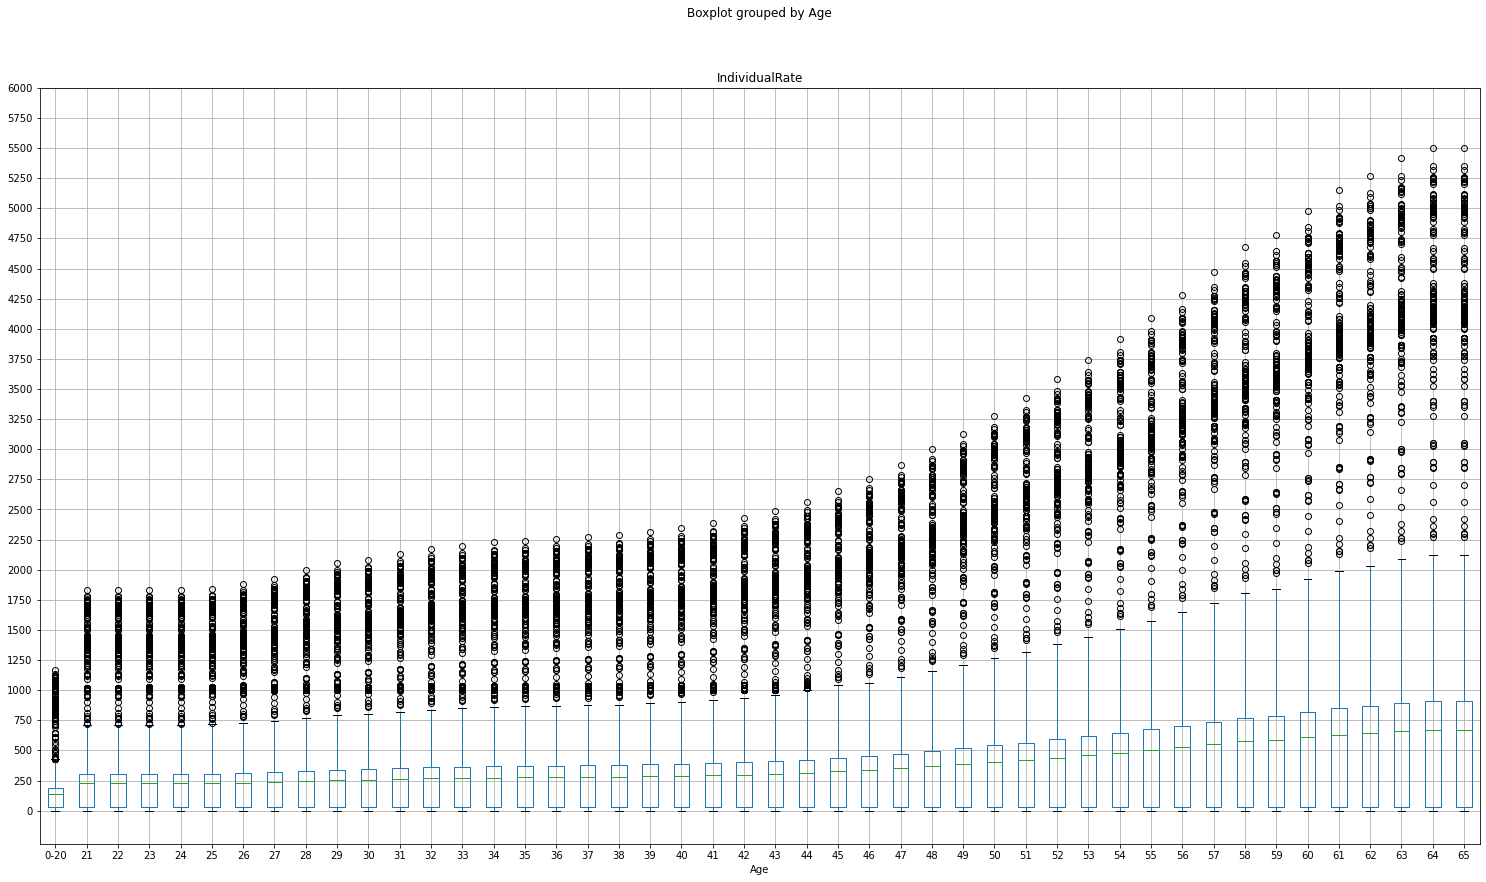

In [58]:
import numpy as np
rate_index = rate_copy.index
ax2 = rate_copy.boxplot(by= "Age", column ="IndividualRate", figsize = (25, 14)) #, title="IndividualRate per country")
ax2.set_yticks(np.arange(0,6250,250))

There is a clear trend of health insurance costs increasing with age. 

More specifically we can see:
* for ages 0-20 median is in range (0,250)
* for ages 20-55 median is in range (250,500)
* for ages >55 median is in range (500,750)

What can also be seen from the graph is that as age increases the range of rate values varies greatly while for younger ages it seems there is less selection or packages or the prices are the same. Also it should be noted that as age increases the maximum rates of health increases almost linearly after age 40, this can be due to people having more health needs and they have to get insurance covering more things or insurance companies charge them more due to their increased health needs.